In [2]:
print("Hello world")

Hello world
Hello world


In [3]:
from gnn_tracking.training.tc import TCModule
from pathlib import Path

In [4]:
from gnn_tracking_hpo.util.paths import find_checkpoint

model_exchange_path = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange"
)
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/"
        ],
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/"
        ],
        stop=5
    ),
)
dm.setup(stage="fit")

[10:38:32] INFO: DataLoader will load 900 graphs (out of 900 available).
[10:38:32] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21999_s0.pt
[10:38:32] INFO: DataLoader will load 5 graphs (out of 1000 available).
[10:38:32] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29004_s0.pt


In [6]:
from gnn_tracking.utils.lightning import find_latest_checkpoint

pdir = Path("/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/pixel/lightning_logs/")
lmodel = TCModule.load_from_checkpoint(find_latest_checkpoint(pdir, "opalescent-aardwolf-of-love")).to("cuda")

[10:40:29] DEBUG: Getting class PreTrainedECGraphTCN from module gnn_tracking.models.track_condensation_networks
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'hc_in' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['hc_in'])`.
  rank_zero_warn(
[10:40:29] DEBUG: Getting class MLGraphConstruction from module gnn_tracking.models.graph_construction
[10:40:29] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[10:40:29] DEBUG: Getting class PotentialLoss from module gnn_tracking.metrics.losses
[10:40:29] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner
[10:40:29] DEBUG: Getting class PulsedNTrials from module gnn_tracking.postprocessing.clusterscanner


In [76]:

from gnn_tracking.training.ml import MLModule

pdir = Path("/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange/gc/")
lmodel = MLModule.load_from_checkpoint(pdir / "pristine-chestnut-badger.ckpt").to("cuda")

[11:11:08] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[11:11:08] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses
[11:11:08] DEBUG: Getting class GraphConstructionKNNScanner from module gnn_tracking.graph_construction.k_scanner


In [77]:
from gnn_tracking.postprocessing.fastrescanner import DBSCANFastRescan

In [86]:
from pytorch_lightning.core.mixins import HyperparametersMixin
from torch_geometric.data import Data
from tqdm import tqdm

import pandas as pd

from gnn_tracking.metrics.cluster_metrics import tracking_metric_df, tracking_metrics, flatten_track_metrics

import numpy as np
from torch import Tensor as T


class OCScanResults:
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def get_mean_results(self):
        return self.df.groupby(["eps", "n_pts"], as_index=False).mean()


class ScanExecutor(HyperparametersMixin):
    # noinspectin PyUnusedLocals
    def __init__(
            self,
            epsilon_range=(0, 1),
            n_pts_range=(1, 4),
            n_samples=100,
            keep_best=0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self._results = []
        self._rng = np.random.default_rng()
        self._trials = []
        self.reset()

    def get_results(self) -> OCScanResults:
        return OCScanResults(pd.DataFrame.from_records(self._results))

    def _reset_trials(self) -> None:
        eps = self._rng.uniform(*self.hparams.epsilon_range, size=self.hparams.n_samples)
        n_pts = self._rng.integers(*self.hparams.n_pts_range, size=self.hparams.n_samples)
        self._trials = [{"eps": e, "n_pts": n} for e, n in zip(eps, n_pts)]

    def reset(self):
        """Reset the results. Will be automatically called every time we run on
        a batch with `i_batch == 0`.
        """
        self._results = []
        self._reset_trials()

    def __call__(self, data: Data, out: dict[str, T], i_batch: int, *, progress=False, ):
        if i_batch == 0:
            self.reset()
        scanner = DBSCANFastRescan(out["H"].detach().cpu().numpy(), )
        iterator  = self._trials
        if progress:
            iterator = tqdm(iterator)
        for trial in iterator:
            labels =scanner.cluster(eps=trial["eps"], min_pts=trial["n_pts"])
            metrics = tracking_metrics(
                truth=data.particle_id.detach().cpu().numpy(),
                predicted=labels,
                pts=data.pt.detach().cpu().numpy(),
                reconstructable=data.reconstructable.detach().cpu().numpy(),
                pt_thlds=[0.9],
            )
            self._results.append({
                "i_batch": i_batch,
                "eps": trial["eps"],
                "n_pts": trial["n_pts"],
                **flatten_track_metrics(metrics),
            })


In [87]:
se = ScanExecutor((0.01, 1), n_samples=100)

In [88]:
for i, data in enumerate(dm.val_dataloader()):
    data = data.detach().to("cuda")
    # data = lmodel.preproc(data)
    out = lmodel(data)
    se(data, out, i, progress=True)

KeyboardInterrupt: 

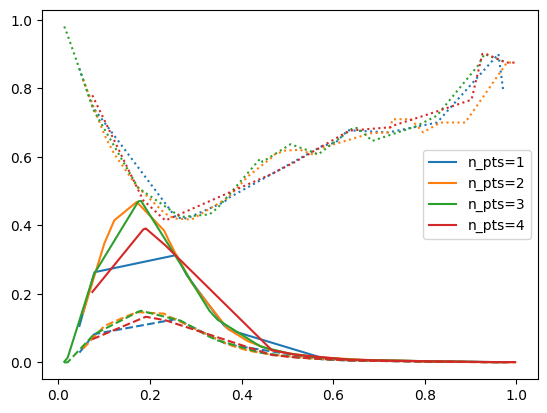

In [85]:
from matplotlib import pyplot as plt

df = se.get_results().get_mean_results()

fig, ax = plt.subplots()
for n_pts in [1, 2, 3, 4]:
    _df = df[df.n_pts == n_pts]
    line, *_ = plt.plot("eps", "double_majority_pt0.9", data=_df, label=f"{n_pts=}")
    c = line.get_color()
    plt.plot("eps", "perfect_pt0.9", data=_df, linestyle="--", color=c, label="")
    plt.plot("eps", "lhc_pt0.9", data=_df, linestyle=":", color=c, label="")

plt.legend()